# Community detection for SA network

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from demon import Demon
from community import community_louvain
from networkx.algorithms.community import k_clique_communities

Reading SeekingAlpha network:

In [2]:
G = nx.read_gexf('SA.gexf')

Calculating communities using Demon algorithm:

In [3]:
demon_communities = Demon(graph=G, epsilon=0.25, min_community_size=3).execute()

Exec: 100%|████████████████████████

Time:  'execute' 0.48 sec
------------------------------------


Setting Demon communities as attributes to graph:

In [4]:
node_to_com = {node: None for node in G.nodes()}
for i, com in enumerate(demon_communities):
    for node in com:
        node_to_com[node] = i+1
nx.set_node_attributes(G, node_to_com, 'demon_community')

Calculating k-clique communities using networkx:

In [5]:
k_cliqs = k_clique_communities(G, 3)

Processing some statistics for the k-clique communities and saving the communities to a list for later access:

In [6]:
cliq_total = 0
cliqs = 0
k_cliq_comms = []
max_kcliq = 0
min_kcliq = 999
for cliq in k_cliqs:
    if len(cliq) < min_kcliq:
        min_kcliq = len(cliq)
    if len(cliq) > max_kcliq:
        max_kcliq = len(cliq)
    k_cliq_comms.append(list(cliq))
    cliq_total += len(cliq)
    cliqs += 1
mean_kcliq = cliq_total / cliqs
k_cliq_comms = sorted(k_cliq_comms, key=len, reverse=True)

Calculating communities using the Louvain algorithm and setting them as attributes to the network:

In [7]:
louvain_comms = community_louvain.best_partition(G)
nx.set_node_attributes(G, louvain_comms, 'louvain_community')

Creating a DataFrame object from node attributes of the network to further analyze statistics of Demon/Louvain communities and characteristics of different communities. K-clique communities were not added, as they can belong to multiple classes, which is not great for tabular data.

In [8]:
nodes_df = pd.DataFrame.from_dict(data=dict(G.nodes(data=True)), orient='index')
nodes_df

,sector,market_cap,ebitda,label,communities,demon_community,louvain_community
ARNA,Healthcare,5763631104,-541788992,ARNA,[ARNA],NaN,0
STLD,Basic Materials,14363883520,4648757760,STLD,[STLD],NaN,24
X,Basic Materials,8431269376,5389000192,X,[X],20.0,24
FB,Communication Services,521496559616,54720000000,FB,[FB],29.0,2
GRPN,Communication Services,502526784,54038000,GRPN,[GRPN],24.0,2
...,...,...,...,...,...,...,...
WERN,Industrials,2851277824,572675904,WERN,[WERN],NaN,11
MSN,Technology,15209664,-3468500,MSN,[MSN],NaN,4
SAVA,Healthcare,1422597248,-20826000,SAVA,[SAVA],NaN,0
DRRX,Healthcare,136503600,-35900000,DRRX,[DRRX],NaN,0


Calculating statistics for Demon/Louvain communities:

In [9]:
demon_comm_counts = nodes_df['demon_community'].value_counts()
demon_comm_mean = demon_comm_counts.mean()
demon_comm_max = demon_comm_counts.max()
demon_comm_min = demon_comm_counts.min()

In [10]:
louvain_comm_counts = nodes_df['louvain_community'].value_counts()
louvain_comm_mean = louvain_comm_counts.mean()
louvain_comm_max = louvain_comm_counts.max()
louvain_comm_min = louvain_comm_counts.min()

Displaying results of some common statistics of the communities:

In [11]:
print(f'Mean size Louvain community: {louvain_comm_mean:.2f}')
print(f'Max size Louvain community: {louvain_comm_max}')
print(f'Min size Louvain community: {louvain_comm_min}\n')
print(f'Mean size Demon community: {demon_comm_mean:.2f}')
print(f'Max size Demon community: {demon_comm_max}')
print(f'Min size Demon community: {demon_comm_min}\n')
print(f'Mean size k-clique community: {mean_kcliq:.2f}')
print(f'Max size k-clique community: {max_kcliq}')
print(f'Min size k-clique community: {min_kcliq}')

Mean size Louvain community: 56.94
Max size Louvain community: 264
Min size Louvain community: 3

Mean size Demon community: 25.96
Max size Demon community: 301
Min size Demon community: 3

Mean size k-clique community: 12.52
Max size k-clique community: 582
Min size k-clique community: 3


Looks like Louvain communities are on average clearly the largest, with Demon showing the smallest maximum group size and k-clique having the largest single group. 

Now we can discover, whether these groups match alongside the real data in use. To explore this we can look at the sectors of the companies within the communities, to see whether the communities are somewhat aligned with the sectors. Initially we can just plot the sector distributions within the whole network.

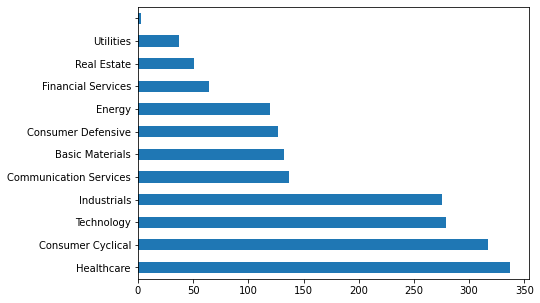

In [12]:
nodes_df['sector'].value_counts().plot(kind='barh', figsize=(7,5))
plt.show()

Then we can visualize some sector distributions of the largest communities for initially Louvain and Demon.

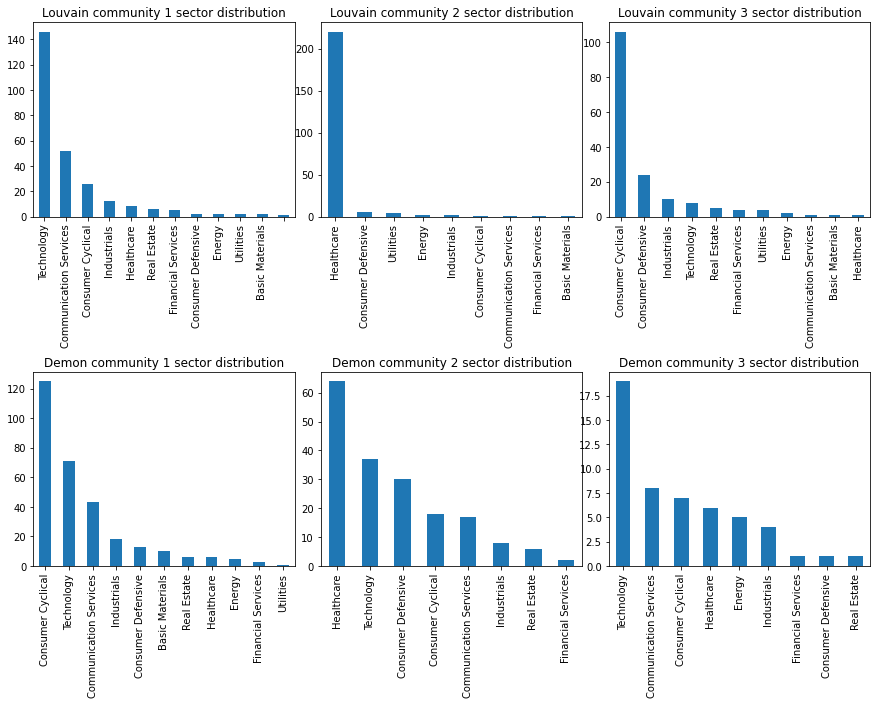

In [13]:
lou_dem = [(louvain_comm_counts, 'louvain_community', 'Louvain'), (demon_comm_counts, 'demon_community', 'Demon')]
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for i in range(3):
    for j, (counts, col_name, name) in enumerate(lou_dem):
        group = counts.index[i]
        nodes_df[nodes_df[col_name]==group]['sector'].value_counts().plot(kind='bar', ax=axs[j,i])
        axs[j,i].set_title(f'{name} community {i+1} sector distribution')
plt.subplots_adjust(wspace=0.1, 
                    hspace=0.8)
plt.show()

It seems that Louvain communities are much better at segmenting out singular sectors from the data. Individual Louvain groups are also larger than those of the Demon communities, showing that the groups of Louvain communities seem to be preferable in this scenario. Now we can also take a look at the k-clique communities.

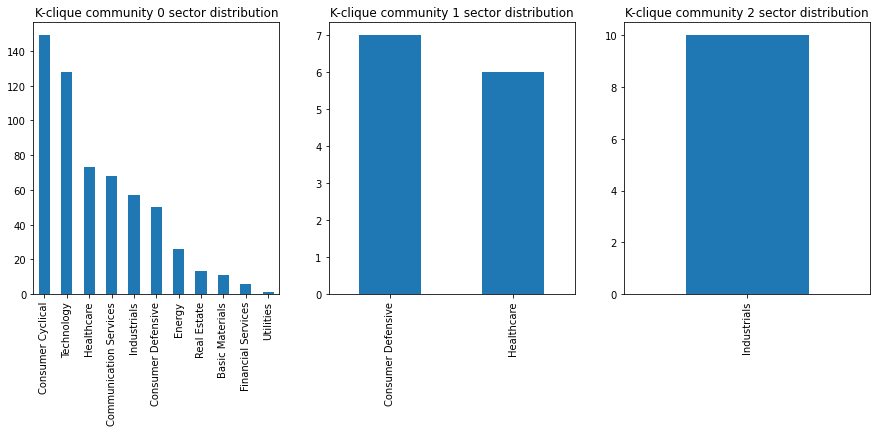

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for i, nodes in enumerate(k_cliq_comms[:3]):
    nodes_df.loc[nodes]['sector'].value_counts().plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'K-clique community {i} sector distribution')

The k-clique communities also seem to perform worse than the Demon/Louvain communities, with the largest community exhibiting quite widely distributed sectors within the community. The second and third communities are only focused within one to two sectors, however, the groups are very small, which makes them perhaps less preferable to the Demon/Louvaine communities.